In [22]:
import pandas as pd
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [23]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [24]:
# # Loading the dataset (using the downloaded file)
# path = "/content/drive/MyDrive/Colab Notebooks/DATA255_Assignment/IMDB_Dataset.csv"
# df = pd.read_csv(path)

In [25]:
df= pd.read_csv("IMDB_Dataset.csv")
df.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
##cleaning up the text
stopWords = set(nltk.corpus.stopwords.words("english"))
def CleanText(text):
    text = text.lower()
    text = re.sub("[^a-z]", " ", text)
    words = [word for word in text.split() if word not in stopWords]
    text = " ".join(words)
    return text

df["review"]=df.apply(lambda row: CleanText(row["review"]), axis=1)
Data = df.review
labels = df.sentiment

In [28]:
### converting 1000 most frequent words to integer
frequentWord = 10000
tokenizer = Tokenizer(num_words=frequentWord)

tokenizer.fit_on_texts(Data)

IntegerizedData = pd.Series(tokenizer.texts_to_sequences(Data))
IntegerizedData.head()

0    [315, 6873, 3237, 2, 117, 996, 1569, 1033, 117...
1    [342, 2080, 100, 30, 3711, 232, 11, 66, 165, 5...
2    [20, 595, 4986, 24, 8579, 369, 844, 7247, 2536...
3    [8, 5767, 24, 749, 582, 180, 304, 147, 2329, 2...
4    [8836, 1155, 25, 3325, 521, 11, 535, 9224, 920...
dtype: object

In [29]:
### You can convert the sequences back to the string
tokenizer.sequences_to_texts(IntegerizedData[0:1])

['mr costner dragged movie far longer necessary aside terrific sea rescue sequences care characters us ghosts closet costner character realized early forgotten much later time care character really care cocky ashton kutcher problem comes kid thinks better anyone else around shows signs closet appears winning costner finally well past half way point stinker costner tells us kutcher ghosts told kutcher driven best prior magic could keep turning hour']

In [30]:
DataLength=IntegerizedData.apply(lambda x: len(x))
DataLength.describe()

count    50000.000000
mean       110.157100
std         81.213625
min          3.000000
25%         60.000000
50%         83.000000
75%        135.000000
max       1104.000000
dtype: float64

The average length of reviews is 110, the shortest review length is 3 and the longest is 1104.

Therefore we need to pad the sequences to equal length.

The following padding function performs zero padding if the length of a sequence is less than the threshold and truncate the ones which are longer than threshold to the threshold.  We choose the threshold to be 256.

In [31]:
#zero padding
IntegerizedData= pad_sequences(IntegerizedData, maxlen=256)


In [32]:
IntegerizedData

array([[   0,    0,    0, ...,  269, 1456,  397],
       [   0,    0,    0, ...,  363,    3,   80],
       [   0,    0,    0, ...,   54,   57,   76],
       ...,
       [   0,    0,    0, ...,  973,   99, 9907],
       [   0,    0,    0, ..., 8508, 3506,   13],
       [   0,    0,    0, ...,   11, 2263,   23]], dtype=int32)

In [33]:
x_train_val,x_test,y_train_val,y_test = train_test_split(IntegerizedData,labels,stratify=labels,test_size=0.20, random_state=42)
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val,stratify=y_train_val,test_size=0.10, random_state=42)

In [34]:
type(x_val)

numpy.ndarray

In [35]:
print(y_train.shape,y_val.shape,y_test.shape)

(36000,) (4000,) (10000,)


## now you have your training, validation and test set as numpy arrays, you can implement the networks

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader
import time

In [37]:
# Define GRU Classifier model
class GRU_b(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(GRU_b, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embed = self.embedding(x)
        output, _ = self.gru(embed)
        # Apply global max pooling 1d
        output = torch.max(output, dim=1)[0]
        x = self.fc1(output)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch 1/80, Time: 1.56s, Train Loss: 0.5029, Val Loss: 0.3388, Train Accuracy: 0.7396, Val Accuracy: 0.8502
Epoch 2/80, Time: 1.52s, Train Loss: 0.2969, Val Loss: 0.3342, Train Accuracy: 0.8751, Val Accuracy: 0.8528
Epoch 3/80, Time: 1.54s, Train Loss: 0.2358, Val Loss: 0.2875, Train Accuracy: 0.9041, Val Accuracy: 0.8845
Epoch 4/80, Time: 1.49s, Train Loss: 0.1917, Val Loss: 0.2841, Train Accuracy: 0.9251, Val Accuracy: 0.8860
Epoch 5/80, Time: 1.48s, Train Loss: 0.1520, Val Loss: 0.3225, Train Accuracy: 0.9431, Val Accuracy: 0.8802
Epoch 6/80, Time: 1.49s, Train Loss: 0.1094, Val Loss: 0.3355, Train Accuracy: 0.9614, Val Accuracy: 0.8822
Epoch 7/80, Time: 1.48s, Train Loss: 0.0777, Val Loss: 0.3783, Train Accuracy: 0.9760, Val Accuracy: 0.8725
Epoch 8/80, Time: 1.47s, Train Loss: 0.0468, Val Loss: 0.4805, Train Accuracy: 0.9875, Val Accuracy: 0.8715
Epoch 9/80, Time: 1.47s, Train Loss: 0.0282, Val Loss: 0.5288, Train Accuracy: 0.9939, Val Accuracy: 0.8658
Epoch 10/80, Time: 1.48s, Tr

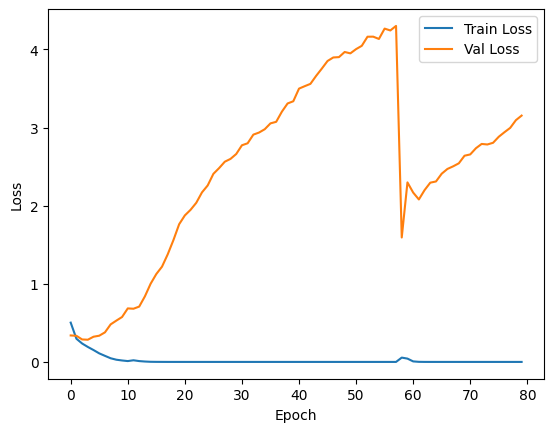

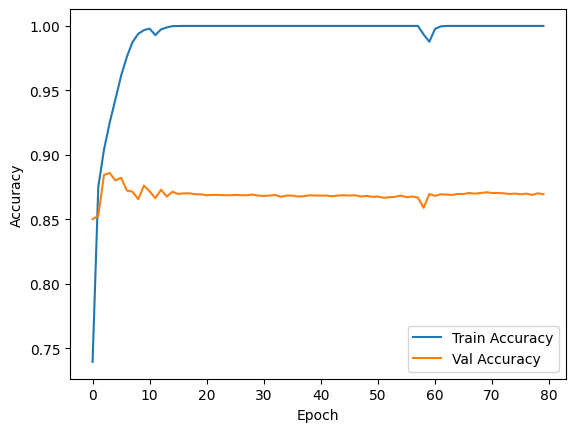

Test Accuracy: 0.8684


In [38]:
# Convert data to PyTorch tensors and move to GPU if available
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).unsqueeze(1).float().to(device)  # Ensure labels are 2D tensor
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).unsqueeze(1).float().to(device)  # Ensure labels are 2D tensor
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64)

# Hyperparameters
embedding_dim = 64  # Since we're using the same embedding dimension as defined in GRU_b
hidden_dim = 64  # Since we're using the same hidden dimension as defined in GRU_b
learning_rate = 0.001
num_epochs = 80

# Instantiate the model and move it to GPU if available
model = GRU_b(frequentWord, embedding_dim, hidden_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values.reshape(-1, 1))
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 1e-3

Epoch 1/80, Time: 0.82s, Train Loss: 0.6956, Val Loss: 0.6922, Train Accuracy: 0.5014, Val Accuracy: 0.5080
Epoch 2/80, Time: 0.66s, Train Loss: 0.6913, Val Loss: 0.6906, Train Accuracy: 0.5427, Val Accuracy: 0.5780
Epoch 3/80, Time: 0.65s, Train Loss: 0.6892, Val Loss: 0.6882, Train Accuracy: 0.5995, Val Accuracy: 0.6082
Epoch 4/80, Time: 0.64s, Train Loss: 0.6861, Val Loss: 0.6846, Train Accuracy: 0.6363, Val Accuracy: 0.6378
Epoch 5/80, Time: 0.63s, Train Loss: 0.6819, Val Loss: 0.6797, Train Accuracy: 0.6603, Val Accuracy: 0.6570
Epoch 6/80, Time: 0.64s, Train Loss: 0.6761, Val Loss: 0.6733, Train Accuracy: 0.6774, Val Accuracy: 0.6650
Epoch 7/80, Time: 0.65s, Train Loss: 0.6675, Val Loss: 0.6632, Train Accuracy: 0.6876, Val Accuracy: 0.6783
Epoch 8/80, Time: 0.65s, Train Loss: 0.6558, Val Loss: 0.6506, Train Accuracy: 0.6995, Val Accuracy: 0.6895
Epoch 9/80, Time: 0.64s, Train Loss: 0.6414, Val Loss: 0.6355, Train Accuracy: 0.7070, Val Accuracy: 0.6973
Epoch 10/80, Time: 0.63s, Tr

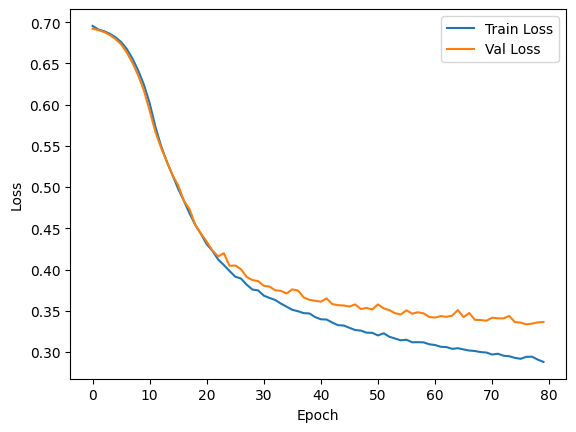

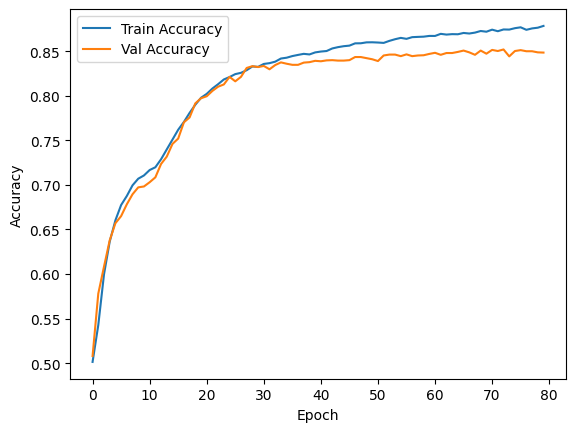

Test Accuracy: 0.8494


In [39]:
# Convert data to PyTorch tensors and move to GPU if available
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).unsqueeze(1).float().to(device)  # Ensure labels are 2D tensor
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).unsqueeze(1).float().to(device)  # Ensure labels are 2D tensor
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64  # Since we're using the same embedding dimension as defined in GRU_b
hidden_dim = 64  # Since we're using the same hidden dimension as defined in GRU_b
learning_rate = 0.0001
weight_decay = 1e-3  # Weight decay parameter
num_epochs = 80

# Instantiate the model and move it to GPU if available
model = GRU_b(frequentWord, embedding_dim, hidden_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Include weight decay

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values.reshape(-1, 1))
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 5e-3
# Best Graph
## Hyperparameters
## L2 Regularization = 5e-3
## Batch Size = 512
## Learning Rate = 0.0001

Epoch 1/140, Time: 0.85s, Train Loss: 0.6935, Val Loss: 0.6926, Train Accuracy: 0.4995, Val Accuracy: 0.5095
Epoch 2/140, Time: 0.64s, Train Loss: 0.6925, Val Loss: 0.6921, Train Accuracy: 0.5173, Val Accuracy: 0.5278
Epoch 3/140, Time: 0.88s, Train Loss: 0.6919, Val Loss: 0.6915, Train Accuracy: 0.5311, Val Accuracy: 0.5435
Epoch 4/140, Time: 0.68s, Train Loss: 0.6912, Val Loss: 0.6907, Train Accuracy: 0.5441, Val Accuracy: 0.5563
Epoch 5/140, Time: 0.65s, Train Loss: 0.6900, Val Loss: 0.6892, Train Accuracy: 0.5807, Val Accuracy: 0.5955
Epoch 6/140, Time: 0.66s, Train Loss: 0.6881, Val Loss: 0.6870, Train Accuracy: 0.6166, Val Accuracy: 0.6335
Epoch 7/140, Time: 0.66s, Train Loss: 0.6854, Val Loss: 0.6839, Train Accuracy: 0.6576, Val Accuracy: 0.6687
Epoch 8/140, Time: 0.64s, Train Loss: 0.6818, Val Loss: 0.6796, Train Accuracy: 0.6790, Val Accuracy: 0.6870
Epoch 9/140, Time: 0.66s, Train Loss: 0.6768, Val Loss: 0.6739, Train Accuracy: 0.6943, Val Accuracy: 0.7030
Epoch 10/140, Time:

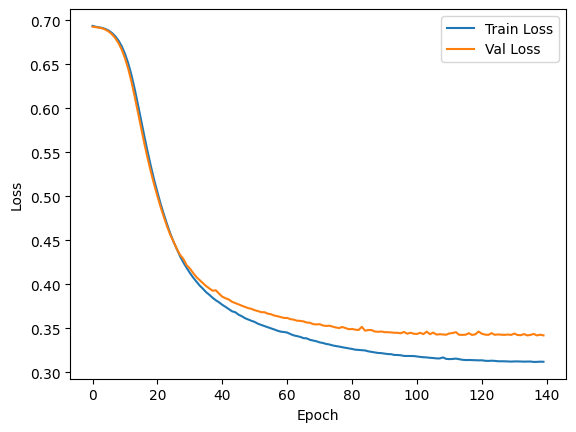

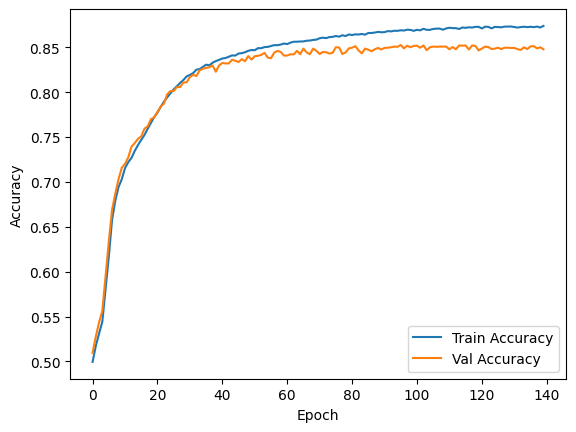

Test Accuracy: 0.8483


In [40]:
# Convert data to PyTorch tensors and move to GPU if available
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).unsqueeze(1).float().to(device)  # Ensure labels are 2D tensor
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).unsqueeze(1).float().to(device)  # Ensure labels are 2D tensor
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64  # Since we're using the same embedding dimension as defined in GRU_b
hidden_dim = 64  # Since we're using the same hidden dimension as defined in GRU_b
learning_rate = 0.0001
weight_decay = 5e-3  # Weight decay parameter
num_epochs = 140

# Instantiate the model and move it to GPU if available
model = GRU_b(frequentWord, embedding_dim, hidden_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Include weight decay

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values.reshape(-1, 1))
print(f'Test Accuracy: {test_accuracy:.4f}')

___

____

____

## L2 Regularization with weight decay of 6e-3

Epoch 1/140, Time: 0.78s, Train Loss: 0.6928, Val Loss: 0.6925, Train Accuracy: 0.5196, Val Accuracy: 0.5337
Epoch 2/140, Time: 0.67s, Train Loss: 0.6923, Val Loss: 0.6919, Train Accuracy: 0.5378, Val Accuracy: 0.5627
Epoch 3/140, Time: 0.65s, Train Loss: 0.6917, Val Loss: 0.6912, Train Accuracy: 0.5671, Val Accuracy: 0.5833
Epoch 4/140, Time: 0.63s, Train Loss: 0.6908, Val Loss: 0.6903, Train Accuracy: 0.5974, Val Accuracy: 0.6052
Epoch 5/140, Time: 0.65s, Train Loss: 0.6897, Val Loss: 0.6890, Train Accuracy: 0.6075, Val Accuracy: 0.6290
Epoch 6/140, Time: 0.63s, Train Loss: 0.6882, Val Loss: 0.6873, Train Accuracy: 0.6516, Val Accuracy: 0.6597
Epoch 7/140, Time: 0.64s, Train Loss: 0.6862, Val Loss: 0.6850, Train Accuracy: 0.6634, Val Accuracy: 0.6840
Epoch 8/140, Time: 0.64s, Train Loss: 0.6834, Val Loss: 0.6818, Train Accuracy: 0.6851, Val Accuracy: 0.6903
Epoch 9/140, Time: 0.64s, Train Loss: 0.6794, Val Loss: 0.6772, Train Accuracy: 0.6933, Val Accuracy: 0.6853
Epoch 10/140, Time:

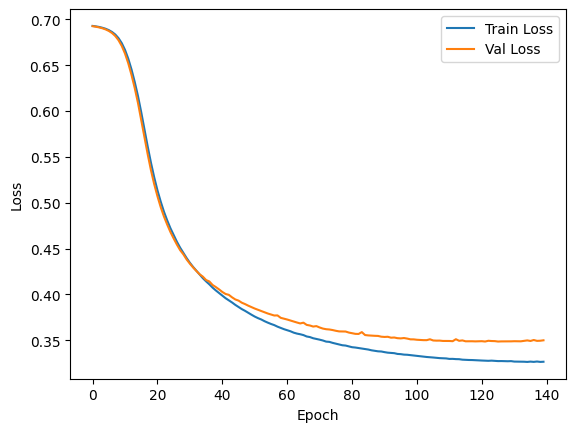

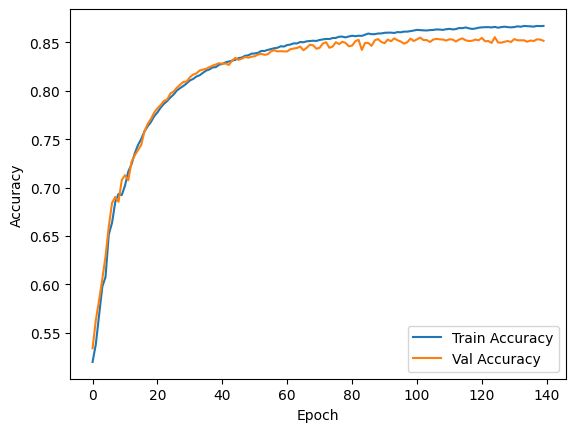

Test Accuracy: 0.8471


In [41]:
# Convert data to PyTorch tensors and move to GPU if available
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).unsqueeze(1).float().to(device)  # Ensure labels are 2D tensor
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).unsqueeze(1).float().to(device)  # Ensure labels are 2D tensor
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64  # Since we're using the same embedding dimension as defined in GRU_b
hidden_dim = 64  # Since we're using the same hidden dimension as defined in GRU_b
learning_rate = 0.0001
weight_decay = 6e-3  # Weight decay parameter
num_epochs = 140

# Instantiate the model and move it to GPU if available
model = GRU_b(frequentWord, embedding_dim, hidden_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Include weight decay

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values.reshape(-1, 1))
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 5e-3

Epoch 1/150, Time: 0.68s, Train Loss: 0.6947, Val Loss: 0.6928, Train Accuracy: 0.5010, Val Accuracy: 0.5022
Epoch 2/150, Time: 0.64s, Train Loss: 0.6924, Val Loss: 0.6918, Train Accuracy: 0.5166, Val Accuracy: 0.5417
Epoch 3/150, Time: 0.92s, Train Loss: 0.6914, Val Loss: 0.6907, Train Accuracy: 0.5462, Val Accuracy: 0.5635
Epoch 4/150, Time: 0.67s, Train Loss: 0.6900, Val Loss: 0.6890, Train Accuracy: 0.5747, Val Accuracy: 0.6030
Epoch 5/150, Time: 0.63s, Train Loss: 0.6878, Val Loss: 0.6862, Train Accuracy: 0.6090, Val Accuracy: 0.6500
Epoch 6/150, Time: 0.64s, Train Loss: 0.6843, Val Loss: 0.6823, Train Accuracy: 0.6458, Val Accuracy: 0.6472
Epoch 7/150, Time: 0.63s, Train Loss: 0.6796, Val Loss: 0.6768, Train Accuracy: 0.6729, Val Accuracy: 0.6720
Epoch 8/150, Time: 0.64s, Train Loss: 0.6727, Val Loss: 0.6689, Train Accuracy: 0.6894, Val Accuracy: 0.6817
Epoch 9/150, Time: 0.63s, Train Loss: 0.6631, Val Loss: 0.6577, Train Accuracy: 0.6980, Val Accuracy: 0.6910
Epoch 10/150, Time:

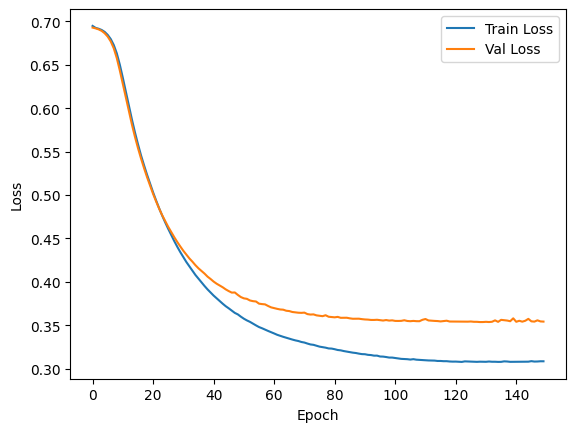

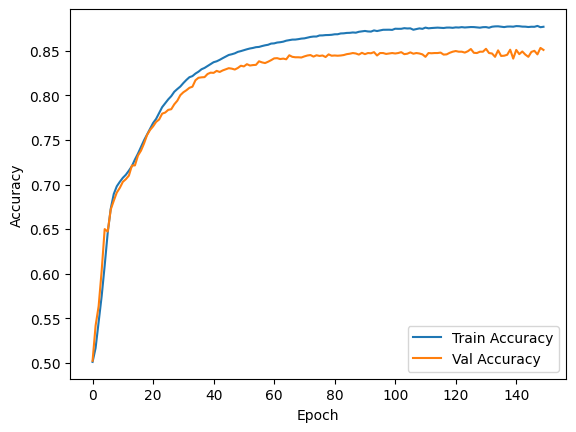

Test Accuracy: 0.8449


In [42]:
# Convert data to PyTorch tensors and move to GPU if available
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).unsqueeze(1).float().to(device)  # Ensure labels are 2D tensor
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).unsqueeze(1).float().to(device)  # Ensure labels are 2D tensor
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64  # Since we're using the same embedding dimension as defined in GRU_b
hidden_dim = 64  # Since we're using the same hidden dimension as defined in GRU_b
learning_rate = 0.0001
weight_decay = 5e-3  # Weight decay parameter
num_epochs = 150

# Instantiate the model and move it to GPU if available
model = GRU_b(frequentWord, embedding_dim, hidden_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Include weight decay

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values.reshape(-1, 1))
print(f'Test Accuracy: {test_accuracy:.4f}')